IMPORTING AND LOADING DATA

In [2]:
#utilities
import re
import numpy as np
import pandas as pd
import sqlite3 as sq3
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset



import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
torch.__version__


import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
#Importing data from the database

path = '/content/drive/MyDrive/Colab Notebooks/Sentiment.db'
con = sq3.Connection(path)
query = """
SELECT *
FROM airline;
"""
dataset = pd.read_sql(query, con)
dataset.columns = ['tweet_id','airline_sentiment','airline_sentiment_confidence','negativereason','negativereason_confidence','airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweetcount', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
dataset = dataset.iloc[1:]
dataset.index = range(len(dataset))
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweetcount,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,None,None,Virgin America,None,cairdin,None,0,@VirginAmerica What @dhepburn said.,None,2015-02-24 11:35:52 -0800,None,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,None,0.0,Virgin America,None,jnardino,None,0,@VirginAmerica plus you've added commercials t...,None,2015-02-24 11:15:59 -0800,None,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,None,None,Virgin America,None,yvonnalynn,None,0,@VirginAmerica I didn't today... Must mean I n...,None,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,None,jnardino,None,0,@VirginAmerica it's really aggressive to blast...,None,2015-02-24 11:15:36 -0800,None,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,None,jnardino,None,0,@VirginAmerica and it's a really big bad thing...,None,2015-02-24 11:14:45 -0800,None,Pacific Time (US & Canada)


In [4]:
#General info about the dataset

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   tweet_id                      14640 non-null  object
 1   airline_sentiment             14640 non-null  object
 2   airline_sentiment_confidence  14640 non-null  object
 3   negativereason                9178 non-null   object
 4   negativereason_confidence     10522 non-null  object
 5   airline                       14640 non-null  object
 6   airline_sentiment_gold        40 non-null     object
 7   name                          14640 non-null  object
 8   negativereason_gold           32 non-null     object
 9   retweetcount                  14640 non-null  object
 10  text                          14640 non-null  object
 11  tweet_coord                   1019 non-null   object
 12  tweet_created                 14640 non-null  object
 13  tweet_location  

TEXT PREPROCESSING & DATA CLEANING

In [5]:
dataset['airline_sentiment'].replace(('neutral', 'positive', 'negative'), (0, 1, -1), inplace=True)
dataset['airline_sentiment'].value_counts()

-1    9178
 0    3099
 1    2363
Name: airline_sentiment, dtype: int64

In [6]:
data_text = dataset['text']
data_text.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [7]:
STOPWORDS=stopwords.words('english')
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data_text = data_text.apply(lambda text: cleaning_stopwords(text))
data_text.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus added commercials experien...
2    @VirginAmerica I today... Must mean I need tak...
3    @VirginAmerica really aggressive blast obnoxio...
4                  @VirginAmerica really big bad thing
Name: text, dtype: object

In [8]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data_text = data_text.apply(lambda x: cleaning_punctuations(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [9]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_text = data_text.apply(lambda x: cleaning_repeating_char(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [10]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_text = data_text.apply(lambda x: cleaning_URLs(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [11]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data_text = data_text.apply(lambda x: cleaning_numbers(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [12]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data_text = data_text.apply(lambda x: stemming_on_text(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [13]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data_text = data_text.apply(lambda x: lemmatizer_on_text(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [14]:
X_train = data_text
X_train.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

MACHINE LEARNING

In [15]:
train_X, test_X, y_train, y_test = train_test_split(X_train, dataset['airline_sentiment'], test_size=0.2, 
                                                    random_state=42, shuffle=True)
print(f'Number of training examples: {len(train_X)}')
print(f'Number of testing examples: {len(test_X)}')

Number of training examples: 11712
Number of testing examples: 2928


In [16]:
#Convert words to vectors

c = CountVectorizer(analyzer = 'word')
X_train = c.fit_transform(train_X)
X_test  = c.transform(test_X)
print(f'Data Transformed.')

Data Transformed.


In [17]:
model_params = {'random_state':50}
LR =  LogisticRegression(**model_params,solver='liblinear')
Forest = RandomForestClassifier()
SVC = SVC(**model_params)

In [18]:
a = LR.fit(X_train, y_train)
b = SVC.fit(X_train, y_train)
c = Forest.fit(X_train, y_train)

In [19]:
print("Train Accuracy using Logistic Regression: ", LR.score(X_train, y_train))
pred_LR = a.predict(X_test)
accuracy = accuracy_score(y_test, pred_LR)
print("Test Accuracy using Logistic Regression: ", accuracy)

print("\nTrain Accuracy using SVC: ", SVC.score(X_train, y_train))
pred_SVC = b.predict(X_test)
accuracy = accuracy_score(pred_SVC, y_test)
print("Accuracy using SVC: ", accuracy)

print("\nTrain Accuracy using RandomForest: ", Forest.score(X_train, y_train))
pred_FOR = c.predict(X_test)
accuracy = accuracy_score(pred_FOR, y_test)
print("Accuracy using RandomForest: ", accuracy)

Train Accuracy using Logistic Regression:  0.9236680327868853
Test Accuracy using Logistic Regression:  0.8155737704918032

Train Accuracy using SVC:  0.9237534153005464
Accuracy using SVC:  0.7909836065573771

Train Accuracy using RandomForest:  0.9972677595628415
Accuracy using RandomForest:  0.7728825136612022


Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.86      0.92      0.89      1889
           0       0.67      0.58      0.62       580
           1       0.77      0.69      0.73       459

    accuracy                           0.82      2928
   macro avg       0.77      0.73      0.75      2928
weighted avg       0.81      0.82      0.81      2928



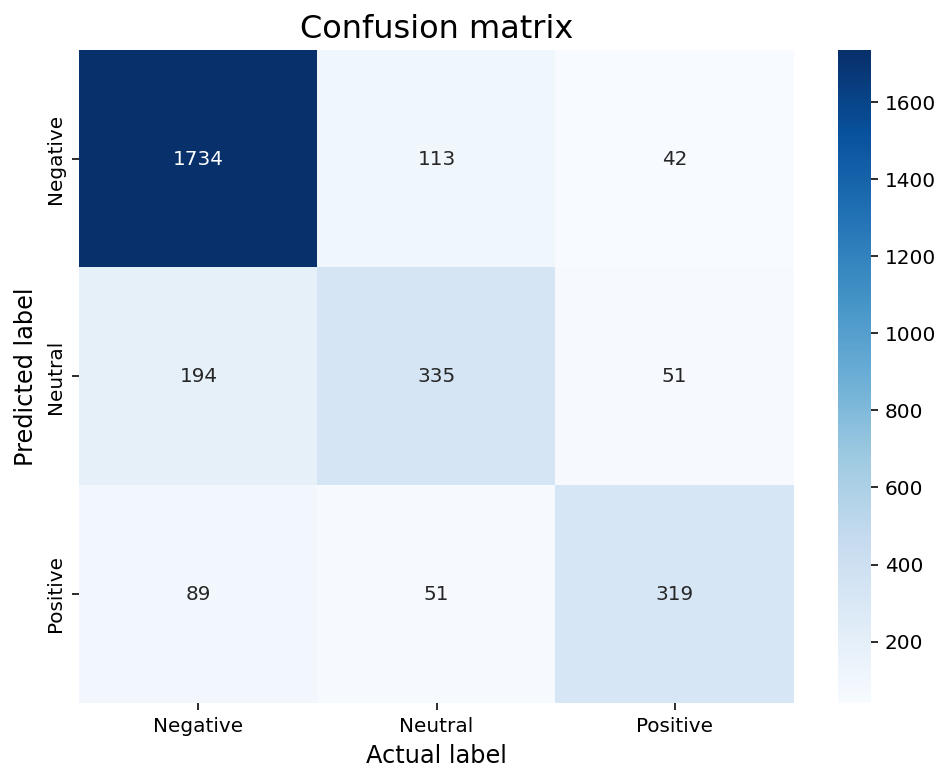

In [30]:
cr = classification_report(y_test, pred_LR)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_LR)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.82      0.93      0.87      1889
           0       0.64      0.50      0.56       580
           1       0.78      0.59      0.68       459

    accuracy                           0.79      2928
   macro avg       0.75      0.67      0.70      2928
weighted avg       0.78      0.79      0.78      2928



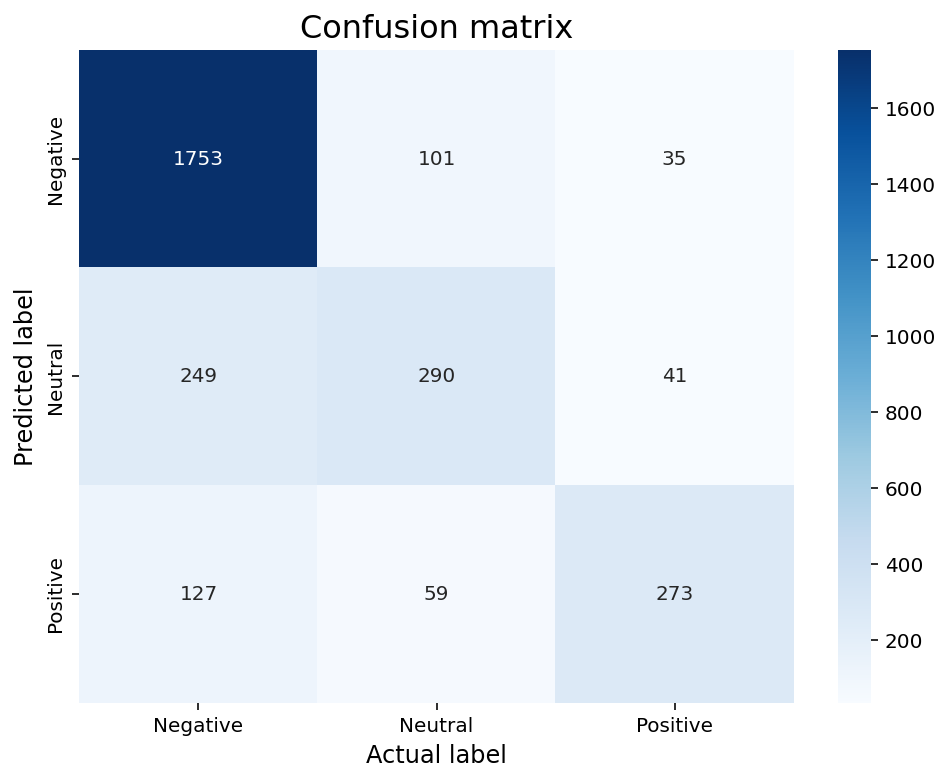

In [23]:
cr = classification_report(y_test, pred_SVC)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_SVC)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.82      0.91      0.86      1889
           0       0.59      0.46      0.52       580
           1       0.75      0.58      0.66       459

    accuracy                           0.77      2928
   macro avg       0.72      0.65      0.68      2928
weighted avg       0.76      0.77      0.76      2928



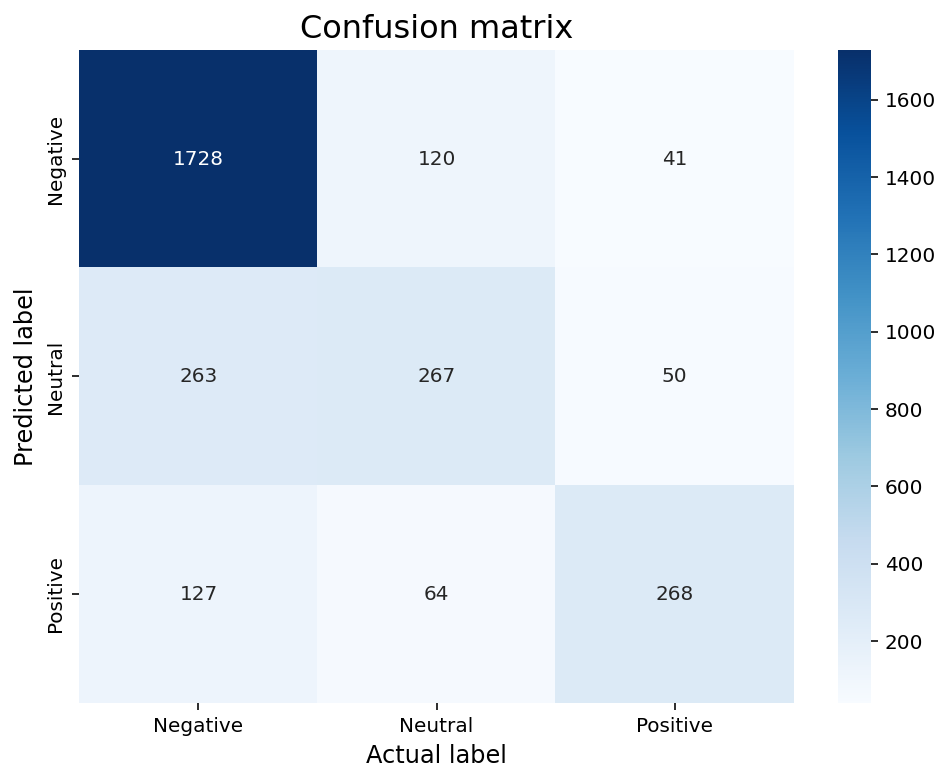

In [24]:
cr = classification_report(y_test, pred_FOR)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_FOR)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

clf = GridSearchCV(svm.SVC(gamma='auto'), {
    'C': [1000],
    'kernel': ['rbf','linear']
}, cv=5, return_train_score=True)
clf.fit(X_train, y_train)
pred_SVC1 = clf.predict(X_test)
print(pred_SVC1)

[ 1 -1 -1 ... -1  0 -1]


In [26]:
accuracy = accuracy_score(pred_SVC1, y_test)
print("Accuracy using RandomForest: ", accuracy)

Accuracy using RandomForest:  0.7995218579234973


Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.85      0.90      0.88      1889
           0       0.63      0.57      0.59       580
           1       0.76      0.66      0.71       459

    accuracy                           0.80      2928
   macro avg       0.75      0.71      0.73      2928
weighted avg       0.79      0.80      0.80      2928



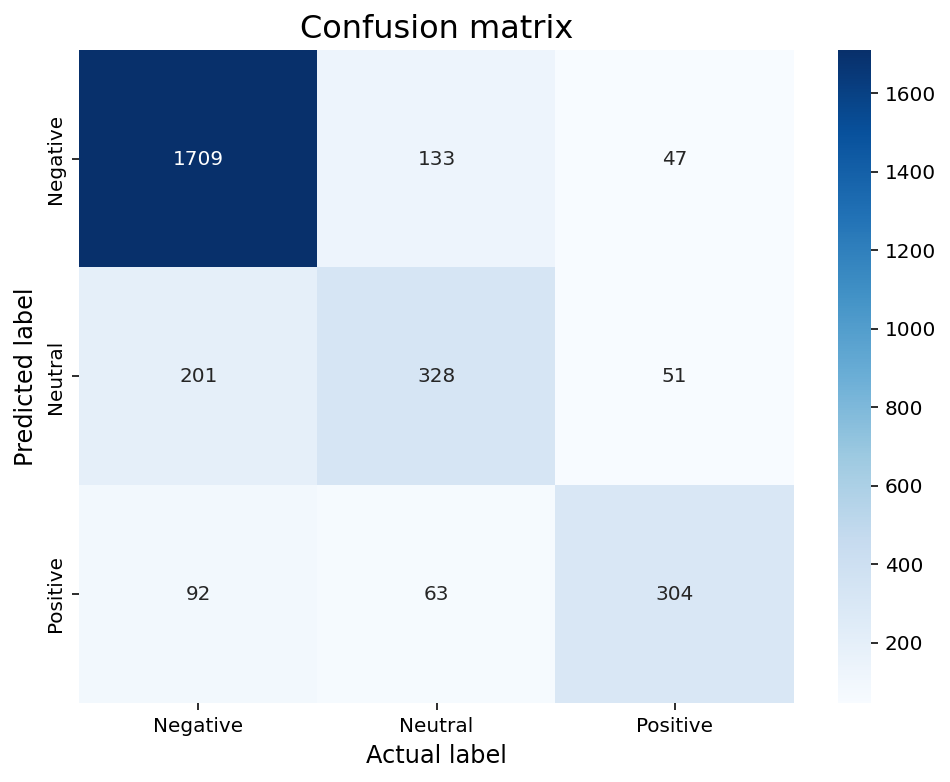

In [31]:
cr = classification_report(y_test, pred_SVC1)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_SVC1)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

clf = GridSearchCV(svm.SVC(gamma='auto'), {
    'C': [1,5,10,15,20,25,30,35,40,45,50,75,100,150,200,500,1000],
    'kernel': ['rbf','linear']
}, cv=5, return_train_score=True)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([ 8.35015564,  8.50692782,  8.33409872, 10.30440722,  8.45307193,
        11.34605861,  8.49621592, 11.94059458,  8.56615853, 12.67739072,
         8.568013  , 12.99686775,  8.52182436, 13.61606617,  8.53523226,
        13.79113827,  8.50215006, 14.71115746,  8.5090436 , 14.72156091,
         8.46769619, 14.75088367,  8.345333  , 15.3482039 ,  8.25783668,
        16.42479405,  8.0788476 , 18.42569976,  8.00962934, 18.28724737,
         7.93801098, 22.77054868,  8.13871536, 25.1674016 ]),
 'mean_score_time': array([1.56888447, 1.11419997, 1.60246234, 1.05428214, 1.62473392,
        1.0333755 , 1.62985806, 1.02187548, 1.63154697, 1.0094779 ,
        1.63821549, 1.00293612, 1.63515186, 1.00303426, 1.62983704,
        1.00151329, 1.62782536, 0.99765072, 1.63478885, 0.99291286,
        1.61772265, 0.98841653, 1.59055986, 0.97635279, 1.56555243,
        0.97411261, 1.54539304, 0.97090511, 1.53323679, 0.96813297,
        1.46911449, 0.96358857, 1.43163805, 0.95599713])

In [4]:
dataset = pd.DataFrame(clf.cv_results_)
dataset.head()

NameError: ignored

In [3]:
dataset[['param_C','param_kernel','mean_test_score','mean_train_score']]

NameError: ignored

In [33]:
from sklearn.linear_model import LogisticRegression

clf = GridSearchCV(LogisticRegression(solver='liblinear',multi_class='auto'), {
    'C': [1000],
}, cv=5, return_train_score=True)
clf.fit(X_train, y_train)
pred_LR1 = clf.predict(X_test)
accuracy = accuracy_score(pred_1, y_test)
print("Accuracy using RandomForest: ", accuracy)

Accuracy using RandomForest:  0.7329234972677595


Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.84      0.82      0.83      1889
           0       0.48      0.53      0.50       580
           1       0.64      0.65      0.65       459

    accuracy                           0.73      2928
   macro avg       0.66      0.66      0.66      2928
weighted avg       0.74      0.73      0.74      2928



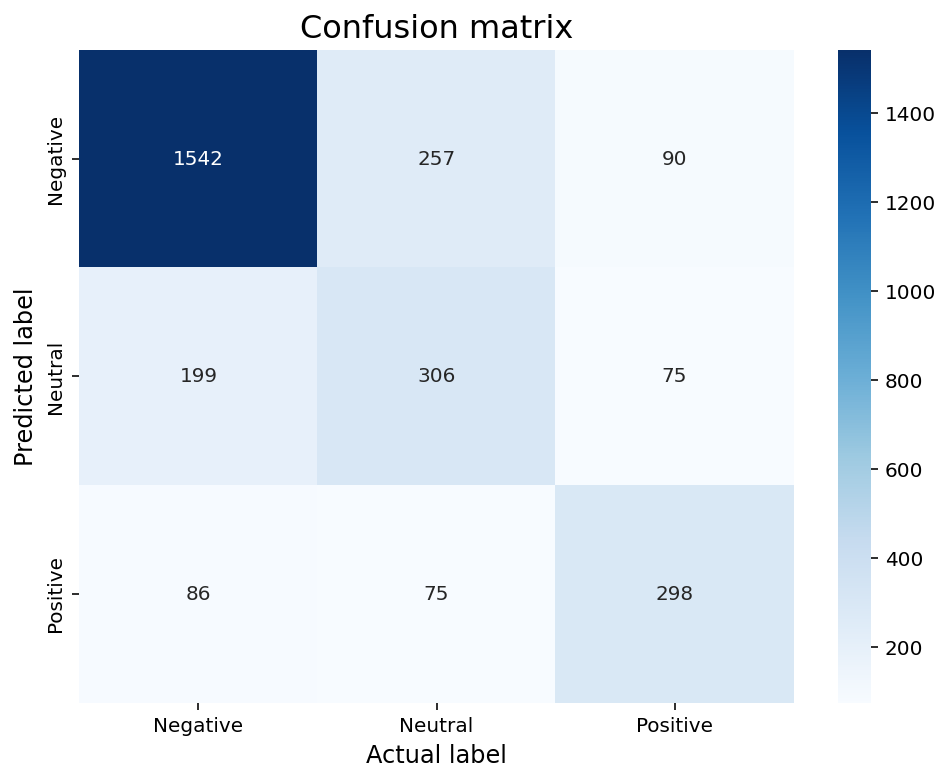

In [34]:
cr = classification_report(y_test, pred_LR1)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_LR1)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression

clf = GridSearchCV(LogisticRegression(solver='liblinear',multi_class='auto'), {
    'C': [1,5,10,15,20,25,30,35,40,45,50,75,100,150,200,500,1000],
}, cv=5, return_train_score=True)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([0.29472375, 0.41456361, 0.4946701 , 0.55647168, 0.58050942,
        0.65724459, 0.69385409, 0.74185734, 0.7498385 , 0.78773823,
        0.80548959, 0.93391533, 0.90018563, 1.02484794, 1.06494875,
        1.24072218, 1.45899138]),
 'mean_score_time': array([0.00147867, 0.00145626, 0.0014833 , 0.00143957, 0.00145988,
        0.00144196, 0.00141773, 0.00146041, 0.00146394, 0.00146422,
        0.00145383, 0.00148683, 0.00145445, 0.00144029, 0.00143218,
        0.00146651, 0.00142474]),
 'mean_test_score': array([0.78278689, 0.77066236, 0.76400266, 0.75802596, 0.75648918,
        0.75503757, 0.75153706, 0.75068301, 0.74965843, 0.7476947 ,
        0.74675551, 0.74265714, 0.73898547, 0.73556995, 0.73206925,
        0.7213968 , 0.71439526]),
 'mean_train_score': array([0.93081885, 0.97412913, 0.98209104, 0.98482328, 0.9865736 ,
        0.98764088, 0.98853741, 0.98911374, 0.98962604, 0.99015968,
        0.99052256, 0.99148311, 0.99248636, 0.99319076, 0.9937244 ,
       

In [23]:
dataset = pd.DataFrame(clf.cv_results_)
dataset.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.294724,0.017466,0.001479,0.000084,1,{'C': 1},0.788306,0.777209,0.784372,0.780102,...,0.782787,0.003811,1,0.931476,0.931583,0.929349,0.930416,0.931270,0.930819,0.000842
1,0.414564,0.021193,0.001456,0.000043,5,{'C': 5},0.775501,0.768246,0.769428,0.770709,...,0.770662,0.002542,2,0.975878,0.973850,0.972999,0.973853,0.974066,0.974129,0.000948
2,0.494670,0.024545,0.001483,0.000081,10,{'C': 10},0.770380,0.758429,0.762596,0.764731,...,0.764003,0.003854,3,0.982709,0.982282,0.980790,0.981857,0.982818,0.982091,0.000734
3,0.556472,0.042714,0.001440,0.000018,15,{'C': 15},0.764405,0.751601,0.756618,0.759607,...,0.758026,0.004159,4,0.986018,0.984844,0.983138,0.984525,0.985592,0.984823,0.000995
4,0.580509,0.028522,0.001460,0.000046,20,{'C': 20},0.760563,0.751174,0.757472,0.756191,...,0.756489,0.003040,5,0.986765,0.986445,0.985592,0.986446,0.987620,0.986574,0.000652


In [24]:
dataset[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,1,0.782787,0.930819
1,5,0.770662,0.974129
2,10,0.764003,0.982091
3,15,0.758026,0.984823
4,20,0.756489,0.986574
5,25,0.755038,0.987641
6,30,0.751537,0.988537
7,35,0.750683,0.989114
8,40,0.749658,0.989626
9,45,0.747695,0.990160


In [35]:
from sklearn.ensemble import RandomForestClassifier

clf = GridSearchCV(RandomForestClassifier(), {
    'n_estimators': [1000],
}, cv=5, return_train_score=True)
clf.fit(X_train, y_train)
pred_FOR1 = clf.predict(X_test)
accuracy = accuracy_score(pred_FOR1, y_test)
print("Accuracy using RandomForest: ", accuracy)

Accuracy using RandomForest:  0.7752732240437158


Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.82      0.92      0.87      1889
           0       0.60      0.46      0.52       580
           1       0.74      0.59      0.65       459

    accuracy                           0.78      2928
   macro avg       0.72      0.65      0.68      2928
weighted avg       0.76      0.78      0.76      2928



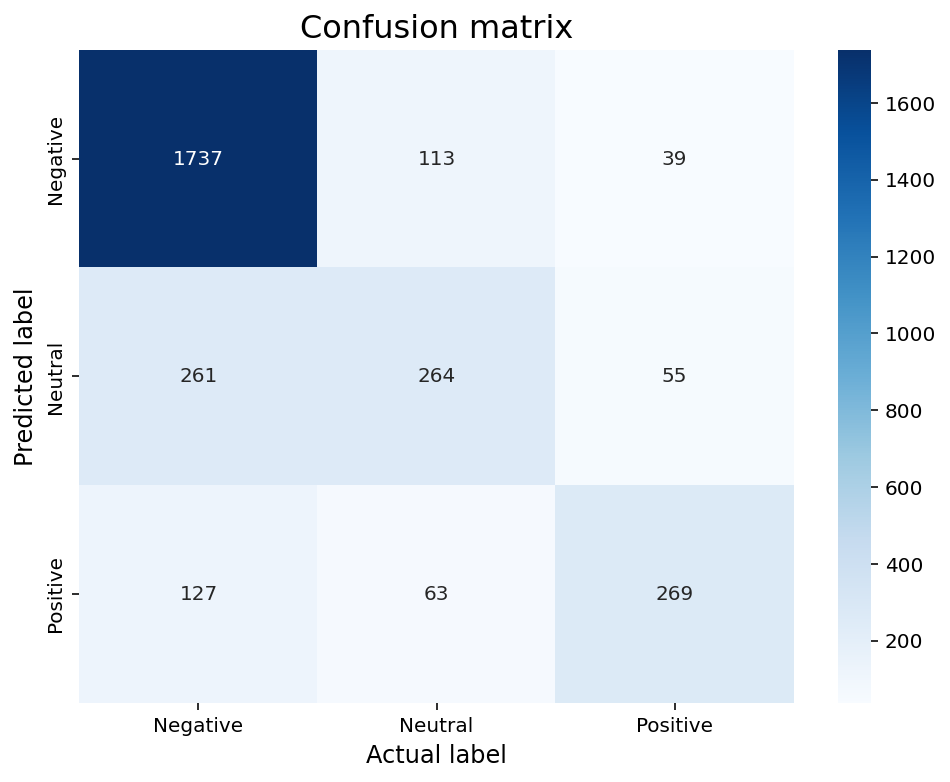

In [36]:
cr = classification_report(y_test, pred_FOR1)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_FOR1)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

In [25]:
from sklearn.ensemble import RandomForestClassifier

clf = GridSearchCV(RandomForestClassifier(), {
    'n_estimators': [1,5,10,15,20,25,30,35,40,45,50,75,100,150,200,500,1000],
}, cv=5, return_train_score=True)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([  0.19870429,   0.99521422,   1.94151731,   2.90641489,
          3.87525439,   4.83026037,   5.79485545,   6.78009677,
          7.75111594,   8.74032235,   9.69939685,  14.51652074,
         19.37211876,  29.11551666,  38.53566761,  96.76493969,
        193.47832046]),
 'mean_score_time': array([0.00316625, 0.01068301, 0.01859121, 0.02706962, 0.03639498,
        0.04671988, 0.05364075, 0.06162062, 0.07112079, 0.07848449,
        0.08650889, 0.13005681, 0.17282276, 0.25613322, 0.34397006,
        0.86733689, 1.75555668]),
 'mean_test_score': array([0.62107362, 0.71072337, 0.73249573, 0.73719224, 0.7463282 ,
        0.74530245, 0.74777813, 0.75017063, 0.75273196, 0.74965785,
        0.74880315, 0.75401193, 0.75486634, 0.75580494, 0.7571709 ,
        0.75682956, 0.7555489 ]),
 'mean_train_score': array([0.85642909, 0.96245307, 0.98292348, 0.99158982, 0.99419396,
        0.99536802, 0.99598701, 0.99688354, 0.997097  , 0.99718238,
        0.99728911, 0.99735314, 0

In [26]:
dataset = pd.DataFrame(clf.cv_results_)
dataset.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.198704,0.005262,0.003166,0.000070,1,{'n_estimators': 1},0.612463,0.615450,0.628096,0.627242,...,0.621074,0.006232,17,0.856015,0.846942,0.856350,0.862327,0.860512,0.856429,0.005322
1,0.995214,0.016857,0.010683,0.001257,5,{'n_estimators': 5},0.723005,0.706359,0.728010,0.695132,...,0.710723,0.012682,16,0.962536,0.963817,0.965101,0.959338,0.961473,0.962453,0.001977
2,1.941517,0.018582,0.018591,0.000260,10,{'n_estimators': 10},0.741784,0.733248,0.730572,0.721178,...,0.732496,0.006766,15,0.981748,0.983136,0.982177,0.983565,0.983991,0.982923,0.000841
3,2.906415,0.016041,0.027070,0.000715,15,{'n_estimators': 15},0.742211,0.736662,0.738685,0.736550,...,0.737192,0.003365,14,0.991781,0.991354,0.991782,0.991249,0.991782,0.991590,0.000238
4,3.875254,0.025817,0.036395,0.001367,20,{'n_estimators': 20},0.753308,0.743491,0.750213,0.746371,...,0.746328,0.005234,12,0.992955,0.994023,0.994771,0.994450,0.994771,0.994194,0.000677


In [27]:
dataset[['param_n_estimators','mean_test_score','mean_train_score']]

,param_n_estimators,mean_test_score,mean_train_score
0,1,0.621074,0.856429
1,5,0.710723,0.962453
2,10,0.732496,0.982923
3,15,0.737192,0.991590
4,20,0.746328,0.994194
5,25,0.745302,0.995368
6,30,0.747778,0.995987
7,35,0.750171,0.996884
8,40,0.752732,0.997097
9,45,0.749658,0.997182
